In [1]:
from graphmodels.graphmodel import GraphModel, concatenate_graph_specs
from graphmodels.validation import score_model, plot_diagnostic, plot_baseline_vs_computation
import pandas as pd
import plotly.express as px
from sklearn.metrics import r2_score
from database import select_dataset
from models.Hermen.model_GE3 import GE3_models

from graphmodels.utils import df_to_data_dict, get_X_y_from_data

# Newer

In [2]:
pop = select_dataset('population')
#emissions = select_dataset('emissions')

In [3]:
emissions = pd.read_csv('models/Hermen/data/GY_GE_GU_GM_GP_GT.csv')

/home/simon/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
emissions.query("Variable == 'TMi' and ISO == 'HUN' and Year == 2017")

,ISO,Item,Description,Year,Unit,Value,Variable,FBS_item
2716916,HUN,All Animals,Total Manure (N content),2017,kg,2.062224e+08,TMi,NaN
2716917,HUN,Asses,Total Manure (N content),2017,kg,6.149520e+04,TMi,NaN
2716918,HUN,Cattle,Total Manure (N content),2017,kg,7.587231e+07,TMi,NaN
2716919,HUN,"Cattle, dairy",Total Manure (N content),2017,kg,2.681802e+07,TMi,NaN
2716920,HUN,"Cattle, non-dairy",Total Manure (N content),2017,kg,4.905429e+07,TMi,NaN
2716921,HUN,Chickens,Total Manure (N content),2017,kg,2.706857e+07,TMi,NaN
2716922,HUN,"Chickens, broilers",Total Manure (N content),2017,kg,1.480383e+07,TMi,NaN
2716923,HUN,"Chickens, layers",Total Manure (N content),2017,kg,1.226474e+07,TMi,NaN
2716924,HUN,Ducks,Total Manure (N content),2017,kg,6.564717e+06,TMi,NaN
2716925,HUN,Goats,Total Manure (N content),2017,kg,1.573520e+06,TMi,NaN


In [4]:
model_df = pd.concat([emissions, pop])
model_df = model_df[~model_df.Item.isin(['All Animals'])]

In [5]:
from graphmodels.utils import df_to_data_dict

def get_X_y_from_data(model, data_dict):
    '''TO CLEAN UP'''
    X = {key: data_dict[key] for key in model.inputs_() + model.parameters_()}
    y = {key: data_dict[key] for key in model.variables_() + model.outputs_() if key in data_dict}
    return X, y


def df_to_dict(df):
    X = {}
    for code in df.columns:
        X[code] = df[code]#.fillna(0)
    return X


def fill_missing_values(df):
    return df
#     return df.groupby(level='ISO').fillna(method='ffill')\
#              .groupby(level='ISO').fillna(method='bfill')


def df_to_data_dict(df, itemized):
    data_dict = {}

    non_item_df = df[~df.Variable.isin(itemized)].pivot(
        index=['ISO', 'Year'], columns='Variable', values='Value')
    non_item_df = fill_missing_values(non_item_df)
    item_df = df[df.Variable.isin(itemized)].pivot(
        index=['ISO', 'Year', 'Item'], columns='Variable', values='Value')

    data_dict.update(df_to_dict(non_item_df))
    data_dict.update(df_to_dict(item_df))

    return data_dict


In [6]:
test = pd.read_csv('outputs/GE3_df.csv')

In [7]:
itemized = ['TAi', 'EF_EEi', 'EECH4', 'TEE_CO2eq',
       'M_ASi', 'EF_ASi', 'E_ASi', 'TMA_CO2eq', 'M_Ti', 'EF_CH4Ti',
       'EF_Ti', 'E_TCH4i', 'E_Ti', 'TMT_CO2eq', 'M_LPi', 'EF_Li', 'E_Li',
       'TMP_CO2eq', 'TMi', 'MM_ASi', 'MM_LPi', 'MM_Ti', 'MYi',]

data_dict = df_to_data_dict(test, itemized)

In [8]:
res = []
for model_name, model in GE3_models.items():
    print(model_name)
    X, y = get_X_y_from_data(model, data_dict)
    print(score_model(model, X, y))
    print()

TMi_model
TMi
    r2  correlation          rmse Variable
0  1.0          1.0  1.795947e-15      TMi

M_xi_model
M_Ti
M_LPi
M_ASi
    r2  correlation          rmse Variable
0  1.0          1.0  5.416115e-16     M_Ti
1  1.0          1.0  5.639518e-16    M_LPi
2  1.0          1.0  4.890020e-16    M_ASi

TMP_CO2eq_model
TMP_CO2eq
         r2  correlation      rmse   Variable
0  0.999998     0.999999  20.88522  TMP_CO2eq

TMT_CO2eq_model
E_Ti
E_TCH4i
TMT_CO2eq
         r2  correlation          rmse   Variable
0  0.999992     0.999997  3.699809e-05       E_Ti
1  1.000000     1.000000  2.893826e-08    E_TCH4i
2  0.999998     0.999999  3.555819e+00  TMT_CO2eq

TMA_CO2eq_model
TMA_CO2eq
         r2  correlation      rmse   Variable
0  0.999993          1.0  1.623531  TMA_CO2eq

TEE_CO2eq_model
TEE_CO2eq
    r2  correlation          rmse   Variable
0  1.0          1.0  7.344046e-10  TEE_CO2eq

FE_CO2eq_model
FE_CO2eq
         r2  correlation         rmse  Variable
0  0.999988     0.999994  4675.

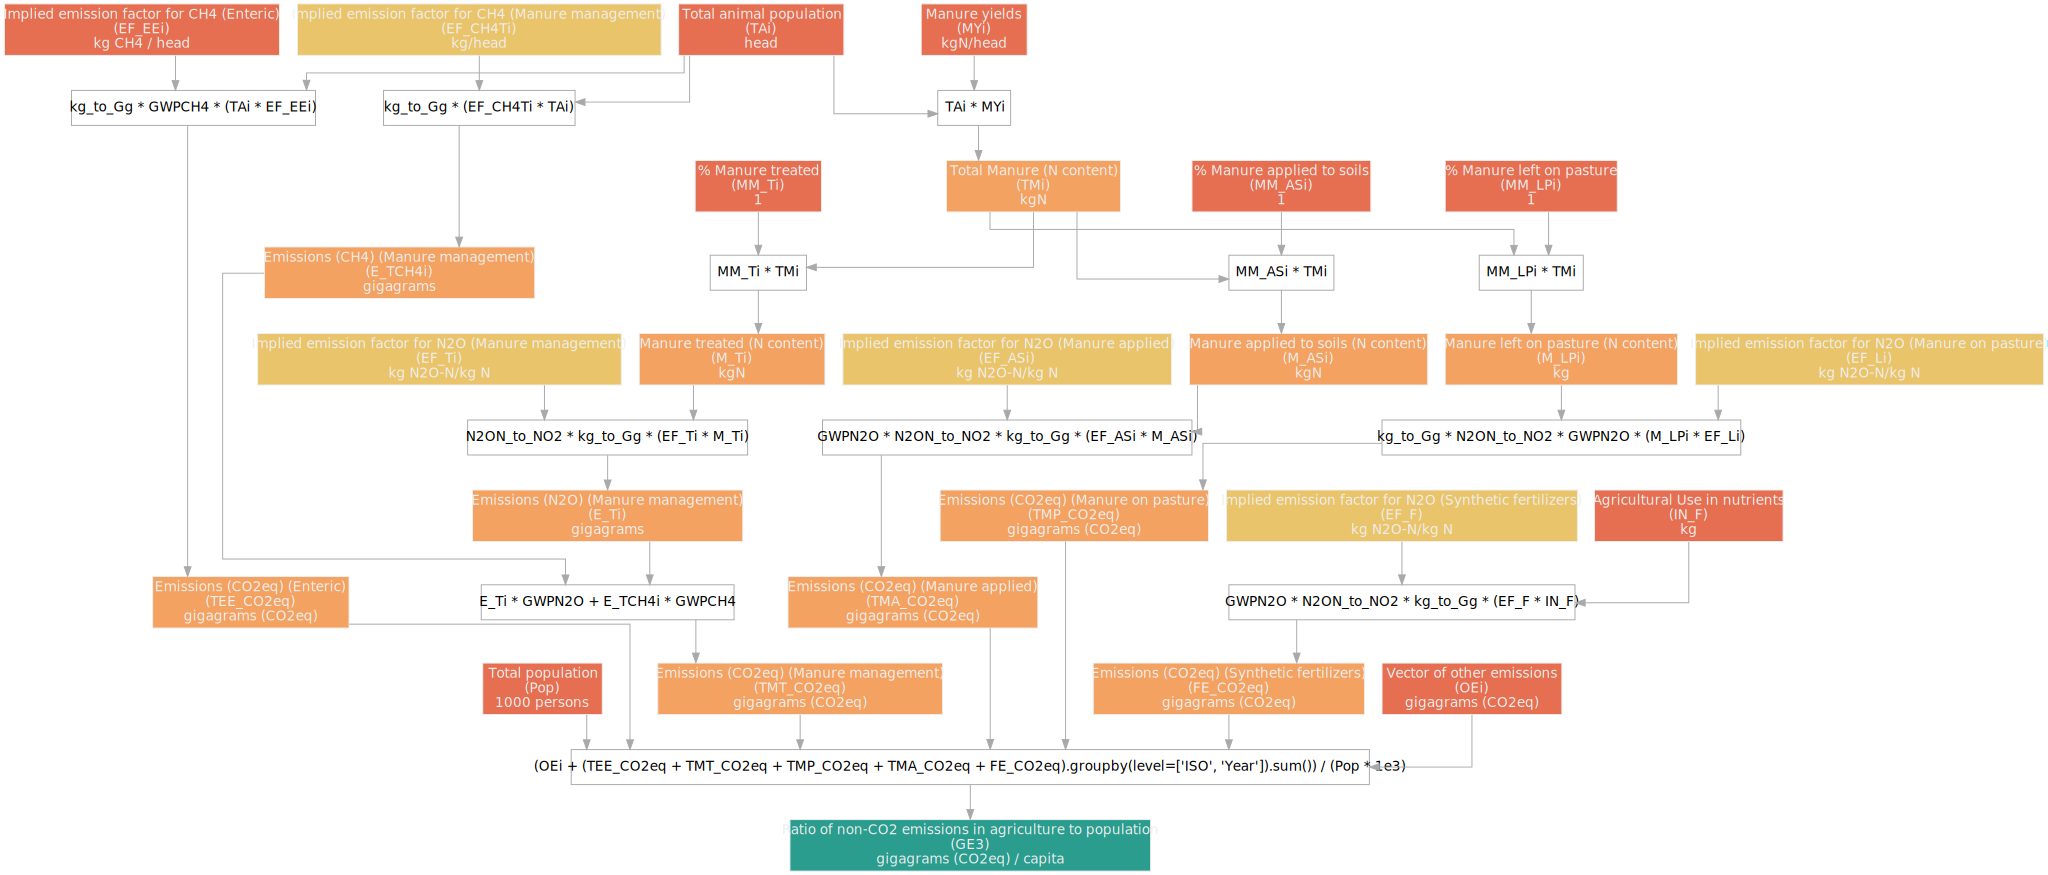

In [9]:
GE3_models['GE3_model'].draw()

In [10]:
X, y = get_X_y_from_data(GE3_models['GE3_model'], data_dict)
res = GE3_models['GE3_model'].run(X)

In [21]:
data_dict['MM_LPi'].loc['HUN', 2017] + data_dict['MM_Ti'].loc['HUN', 2017] + data_dict['MM_ASi'].loc['HUN', 2017] 

Item
Asses                 1.0
Cattle                1.0
Cattle, dairy         1.0
Cattle, non-dairy     1.0
Chickens              1.0
Chickens, broilers    1.0
Chickens, layers      1.0
Ducks                 1.0
Goats                 1.0
Horses                1.0
Mules                 1.0
Mules and Asses       1.0
Poultry Birds         1.0
Sheep                 1.0
Sheep and Goats       1.0
Swine                 1.0
Swine, breeding       1.0
Swine, market         1.0
Turkeys               1.0
dtype: float64

In [24]:
res['MM_LPi'].loc['FRA', 2015].dropna() + res['MM_Ti'].loc['FRA', 2015].dropna() + res['MM_ASi'].loc['FRA', 2015].dropna() 

Item
Asses                 1.0
Cattle                1.0
Cattle, dairy         1.0
Cattle, non-dairy     1.0
Chickens              1.0
Chickens, broilers    1.0
Chickens, layers      1.0
Ducks                 1.0
Goats                 1.0
Horses                1.0
Mules                 1.0
Mules and Asses       1.0
Poultry Birds         1.0
Sheep                 1.0
Sheep and Goats       1.0
Swine                 1.0
Swine, breeding       1.0
Swine, market         1.0
Turkeys               1.0
dtype: float64

In [ ]:
res['MM_Ti'].loc['FRA', 2014].dropna()

In [ ]:
res['MM_ASi'].loc['FRA', 2014].dropna()

In [ ]:
#test = test.append({'Item': 'FE_CO2eq', 'Value': data_dict['FE_CO2eq'].loc['FRA', 2014], 'Variable':'Agricultural non-CO2 emissions'}, ignore_index=True)

#test = test.append({'Item': 'OEi_CO2eq', 'Value': data_dict['OEi'].loc['FRA', 2014], 'Variable':'Agricultural non-CO2 emissions'}, ignore_index=True)

#test = test.append({'Item': 'lalal', 'Value': 10000, 'Variable':'OEi_CO2eq'}, ignore_index=True)

In [ ]:
def run_GE3_scenario(data_dict, MM_Ti=1/3, MM_ASi=1/3, MM_LPi=1/3):

    data_dict = data_dict.copy()

    data_dict['MM_Ti'] = MM_Ti
    data_dict['MM_ASi'] = MM_ASi
    data_dict['MM_LPi'] = MM_LPi

    results = GE3_models['GE3_model'].run(data_dict)

    return results

In [16]:
filtered_data_dict = {k: v.loc['FRA', 2018, :] for k, v in data_dict.items()}

In [17]:
result =  run_GE3_scenario(filtered_data_dict, 1/3, 1/3, 1/3)

In [28]:
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [30]:
test = {k: v for k, v in result.items() if k in ['TEE_CO2eq', 'TMA_CO2eq', 'TMT_CO2eq', 'TMP_CO2eq']}
def format_data_dict_sankey(data_dict=test):
    data_dict = data_dict.copy()

    # grab data and format
    data = pd.concat([v.to_frame(name='Value').assign(Variable=k) for k, v in data_dict.items()], axis=0).reset_index().dropna()
    
    data = pd.concat([data, data.groupby('Variable').sum().reset_index().rename(columns={"Variable": 'Item'}).assign(Variable='Non-CO2 agricultural emissions')])

    # add encoding for Sanky
    le = LabelEncoder() 
    encoded = le.fit_transform(data[['Item', 'Variable']].values.flatten()).reshape(-1, 2)

    data[['Source', 'Target']] = encoded

    return data,  le.classes_

def plot_sanky_GE3(data, classes):
    '''To improve, should write a more general wrapper for Sankey'''

    fig = go.Figure(data=[go.Sankey(
        node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = classes,
        #color = "blue"
        ),
        link = dict(
        target = data['Target'],
        source= data['Source'],
        value = data['Value']
    ))])

    fig.update_layout(title_text=f"Agricultural Animal Emissions", font_size=10)
    return fig


d, c = format_data_dict_sankey()


fig = plot_sanky_GE3(d, c)

In [34]:
fig['data'][0]

Sankey({
    'link': {'source': array([ 0,  1,  2,  6,  7,  8, 10, 11, 12,  0,  1,  2,  3,  4,  5,  6,  7,  8,
                              10, 11, 12, 17,  0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 17,  0,  1,  2,
                               3,  4,  5,  6,  7,  8, 10, 11, 12, 17, 13, 14, 15, 16]),
             'target': array([13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14,
                              14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16,
                              16, 16, 16, 16, 16, 16, 16, 16, 16, 16,  9,  9,  9,  9]),
             'value': array([6.39660000e+00, 8.72833525e+03, 1.79485913e+04, 1.36358880e+02,
                             1.40193018e+02, 5.87748000e+00, 1.18309061e+03, 4.19728680e+01,
                             3.77755906e+02, 9.06669345e-01, 1.31605982e+03, 2.66760100e+03,
                             1.76754947e+02, 1.71045725e+02, 8.99713158e+01, 5.63595035e+01,
                             3.2014